In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_met
import glob
import metpy
from metpy import calc
from metpy.units import units
from scipy import stats
import metpy
from metpy import calc
from metpy.units import units
import pickle as pkl

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
dry_test = xr.open_dataarray('/media/ck/Elements/SouthAmerica/CHIRPS/dry_spells_1mm_3-7days_StartOfSpell.nc')
wet_test = xr.open_dataarray('/media/ck/Elements/SouthAmerica/CHIRPS/wet_spells_1mm_3-7days_StartOfSpell.nc')
dry_test.name = 'dry'
wet_test.name = 'wet'

In [4]:
regions = {
'equatorial' : [(-5,0)],
'transition' : [(-8,-5)],
'central' : [(-12,-8)],
'southern' : [(-18,-15)]}
h = 2000

In [5]:
height = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/topo_ERA5_peru.nc')

In [6]:
dummy = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/*.nc')[0]).isel(time=0, level=0)
dummy = uda.flip_lat(dummy)

In [7]:
dry = dummy.salem.transform(dry_test, interp='nearest').where(height>=h)
wet = dummy.salem.transform(wet_test, interp='nearest').where(height>=h)

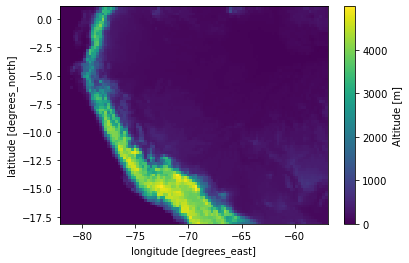

In [40]:
height['h'].plot()


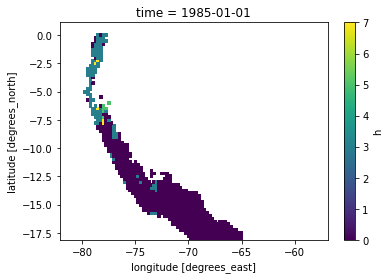

In [44]:
dry['h'].isel(time=0).plot()

In [46]:
height

<xarray.Dataset>
Dimensions:    (latitude: 77, longitude: 101)
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -57.5 -57.25 -57.0
  * latitude   (latitude) float32 -18.0 -17.75 -17.5 -17.25 ... 0.5 0.75 1.0
Data variables:
    h          (latitude, longitude) float64 0.0 0.0 0.0 ... 268.4 239.4 188.4

In [60]:
maxlon = height.argmax(dim='longitude')

In [74]:
picklon = height.longitude[maxlon['h']]

In [75]:
picklon

<xarray.DataArray 'longitude' (latitude: 77)>
array([-69.  , -69.5 , -69.75, -70.  , -70.  , -70.  , -70.25, -70.25, -71.  ,
       -71.5 , -70.75, -71.  , -69.25, -69.25, -72.5 , -70.25, -70.75, -71.  ,
       -75.  , -74.75, -75.25, -75.5 , -75.5 , -76.  , -76.  , -75.  , -76.25,
       -76.5 , -76.5 , -76.  , -76.  , -77.  , -77.  , -77.25, -77.25, -77.5 ,
       -77.5 , -77.75, -77.75, -77.75, -78.  , -77.5 , -77.5 , -78.25, -78.5 ,
       -78.5 , -78.5 , -79.25, -77.5 , -79.25, -79.25, -79.5 , -79.5 , -79.5 ,
       -79.25, -79.  , -79.25, -79.25, -79.5 , -79.  , -79.25, -79.25, -78.75,
       -78.5 , -78.5 , -78.5 , -78.75, -78.75, -78.75, -78.5 , -78.25, -78.25,
       -78.  , -78.  , -77.75, -78.  , -77.75], dtype=float32)
Coordinates:
    longitude  (latitude) float32 -69.0 -69.5 -69.75 ... -77.75 -78.0 -77.75
  * latitude   (latitude) float32 -18.0 -17.75 -17.5 -17.25 ... 0.5 0.75 1.0
Attributes:
    units:      degrees_east
    long_name:  longitude

In [76]:
longrid = np.repeat(np.expand_dims(picklon.values,axis=1), height.longitude.shape, axis=1)
lontrue = np.repeat(np.expand_dims(dry.longitude.values,axis=0), dry.latitude.shape, axis=0)

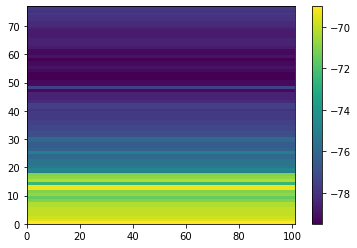

In [77]:
plt.pcolormesh(longrid)
plt.colorbar()

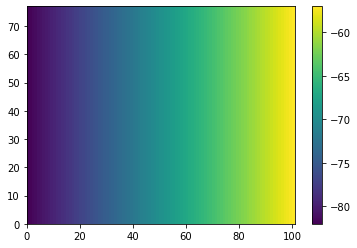

In [78]:
plt.pcolormesh(lontrue)
plt.colorbar()

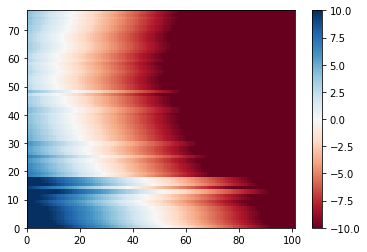

In [81]:
plt.pcolormesh(longrid-lontrue, cmap='RdBu', vmin=-10, vmax=10)
plt.colorbar()

In [82]:
western = (longrid-lontrue)>0
eastern = (longrid-lontrue)<0

In [83]:
num_pix = {}
for rr in regions.keys():
    print(rr)
    als = regions[rr]
    dd = dry['h'].isel(time=5).sel(latitude=slice(als[0][0], als[0][1]))
    vals = dd.where(np.isfinite(dd)).count(['latitude', 'longitude']).values
    print(vals)
    num_pix[rr] =  vals

equatorial
69
transition
58
central
132
southern
278


In [84]:
def get_spells(region, spell_ds,spell_length, equal=None, gt=None, lt=None, perc=0.15, divide=None):
     
    alls = regions[region]
    
    #times = spell_ds.time

    
    mask = 0
    if gt is not None:
        mask = spell_ds >= spell_length
    if equal is not None:
        mask = spell_ds == spell_length
    if lt is not None:
        mask = (spell_ds >= 3) & (spell_ds <= spell_length)
        
    if divide is not None:
        mask = mask & divide
    
    #ipdb.set_trace()
#     dry_region = spell_ds['h'].sel(latitude=slice(alls[0][0], alls[0][1])).where(mask).count('longitude').squeeze()
#     dry_region_all = spell_ds['h'].sel(latitude=slice(alls[0][0], alls[0][1])).where(np.isfinite(spell_ds)).count('longitude').squeeze()
#     #ipdb.set_trace()
#     dry_dates = dry_region.where((dry_region.mean(['latitude'])/dry_region_all.mean(['latitude'])>0.25), drop=True)  # fraction covered by spell, 0.25 means 25% of pixels on day

    dry_region = spell_ds['h'].sel(latitude=slice(alls[0][0], alls[0][1])).where(mask).count(['longitude','latitude']).squeeze()
    dry_region_all = spell_ds['h'].sel(latitude=slice(alls[0][0], alls[0][1])).where(np.isfinite(spell_ds)).count(['longitude', 'latitude']).squeeze()
    #ipdb.set_trace()
    dry_dates = dry_region.where((dry_region/dry_region_all)>perc, drop=True)  # fraction covered by spell, 0.25 means 25% of pixels on day
    
    
    
#     dry_region_area = spell_ds['h'].sel(latitude=slice(alls[0][0], alls[0][1])).where(mask).count(['latitude', 'longitude']).squeeze()
#     dry_dates = dry_region_area.where(dry_region_area>=50, drop=True)
    #ipdb.set_trace()
    #plt.plot(dry_region_area['h'])

    drydates = []
    #ipdb.set_trace()
    for dryd in dry_dates.time:
            drydates.append(pd.Timestamp(dryd.values))
    out = pd.to_datetime(drydates)
    
    print('Len', len(out))
    
    return pd.to_datetime(drydates)

In [86]:
for pr in ['equatorial', 'transition', 'central','southern']:  # 
    
    perc=0.15
    side=western
    
    drydates = get_spells(pr, dry,3, equal=True, perc=perc, divide=side)
    wetdates = get_spells(pr, wet,3, equal=True, perc=perc, divide=side)
    drydates5 = get_spells(pr, dry,5,lt=True, perc=perc, divide=side)
    wetdates5 = get_spells(pr, wet,5,lt=True, perc=perc, divide=side)
    drydates7 = get_spells(pr, dry,5,gt=True, perc=perc, divide=side)
    wetdates7 = get_spells(pr, wet,5,gt=True, perc=perc, divide=side)
    
    dic = {
    'dry3' : drydates,
    'wet3' : wetdates,
    'dry5' : drydates5,
    'wet5' : wetdates5,
    'dry7' : drydates7,
    'wet7' : wetdates7,
       }
    pkl.dump(dic, open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+pr+"_dw_spellDates_"+str(perc)+"perc_western_v2.p", "wb"))

Len 42
Len 19
Len 114
Len 37
Len 46
Len 4
Len 90
Len 58
Len 189
Len 88
Len 87
Len 16
Len 25
Len 23
Len 61
Len 42
Len 22
Len 9
Len 4
Len 3
Len 14
Len 7
Len 6
Len 1
